# Stock Options Exploration

Here, we'll perform some studies to better understand the data and simulate some strategies.

In [2]:
# @title Configuration

import glob
import warnings
import pandas as pd
import numpy as np
from scipy.stats import norm
import statistics
from dataclasses import dataclass, asdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from typing import List, Dict, Callable
from functools import partial
from sklearn.base import ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from google.colab import drive

##### Configuration #####
drive.mount("/content/drive/")
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_palette("mako")
tqdm.pandas()

##### Constants #####

## Tickers ##
PETR4_TICKER = "PETR4"
VALE3_TICKER = "VALE3"
ITUB4_TICKER = "ITUB4"
BBAS3_TICKER = "BBAS3"
ABEV3_TICKER = "ABEV3"
BBDC4_TICKER = "BBDC4"
BOVA11_TICKER = "BOVA11"

## Data ##
DATA_FOLDER_PATH = "/content/drive/MyDrive/UFC/TCC_STOCK_OPTIONS/stock-options/data/"
COLUMNS = [
    "data_pregao",
    "cod_negociacao", # E.g. PETR4, VALE3
    "especificacao_papel",
    "tipo_mercado",
    "preco_ultimo_negocio",
    "preco_maximo",
    "volume_total_negociado",
    "preco_exercicio",
    "data_vencimento",
]
NUMERICAL_COLUMNS = [
    "preco_ultimo_negocio",
    "preco_maximo",
    "volume_total_negociado",
    "preco_exercicio",
]
DATE_COLUMNS = ["data_pregao", "data_vencimento"]

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
# @title Load the Processed Data

##### Stocks #####

stock_df_dict = {}
for ticker in [
    PETR4_TICKER,
    VALE3_TICKER,
    ITUB4_TICKER,
    BBAS3_TICKER,
    ABEV3_TICKER,
    BBDC4_TICKER,
    BOVA11_TICKER,
]:
    stock_df_dict[ticker] = pd.read_csv(
        DATA_FOLDER_PATH + f"processed_data/{ticker.lower()}_stock.csv",
        parse_dates=["data_pregao"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
    )

##### Calls #####

call_df_dict = {}
for ticker in [
    PETR4_TICKER,
    VALE3_TICKER,
    ITUB4_TICKER,
    BBAS3_TICKER,
    ABEV3_TICKER,
    BBDC4_TICKER,
    BOVA11_TICKER,
]:
    call_df_dict[ticker] = pd.read_csv(
        DATA_FOLDER_PATH + f"processed_data/{ticker.lower()}_call.csv",
        parse_dates=["data_pregao", "data_vencimento"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
    )

In [4]:
# @title Selic Rate

# @markdown In Brazil, the interest risk-free rate is the Selic rate.

selic_df = pd.read_csv(DATA_FOLDER_PATH + "selic.csv")
selic_df["release_date"] = pd.to_datetime(selic_df["release_date"], format="%d/%m/%Y")

def get_current_selic(date: datetime) -> float:
    return selic_df[selic_df["release_date"] <= date]["selic"].iloc[0]/100

### Volatility

#### Historical Volatility
Our measure of volatility will be the anual historical standard deviation of the stock price. Usually, we can calculate it as the following.  

$$DailyReturn_i = {StockPrice_{i+1} - StockPrice_{i} \over StockPrice_{i}}$$  

$$ AnnualHistoricalSD = \sqrt{252} * \sqrt{\sum_{i=1}^{n}(DailyReturn_i - \overline{DailyReturn})^2 \over n - 1}$$

However, as we'll see later, we want to compare the historical volatility with the implied one by the Black-Scholes Model. To do so, we have to make the following change in the way the daily return is calculated.

$$DailyReturn_i = ln({StockPrice_{i+1} - StockPrice_{i} \over StockPrice_{i}})$$  

In [6]:
def annualized_hist_volatility(
    stock_df: pd.DataFrame,
    end_date: datetime = datetime(year=2022, month=7, day=4),
    offset: int = 20 # How far in the past
) -> float:
    end_idx = stock_df[stock_df["data_pregao"] == end_date].index[0]
    df = stock_df.iloc[max(0, end_idx-offset+1):end_idx+1]
    return np.log(df["preco_ultimo_negocio"]/df["preco_ultimo_negocio"].shift(1)).std()*math.sqrt(252)

print(
    f"PETR4 Annualized Volatility: {100*annualized_hist_volatility(stock_df_dict[PETR4_TICKER], end_date=stock_df_dict[PETR4_TICKER]['data_pregao'].max(), offset=stock_df_dict[PETR4_TICKER].shape[0]):.2f}%\n"
)
print(
    f"VALE3 Annualized Volatility: {100*annualized_hist_volatility(stock_df_dict[VALE3_TICKER], end_date=stock_df_dict[VALE3_TICKER]['data_pregao'].max(), offset=stock_df_dict[VALE3_TICKER].shape[0]):.2f}%"
)

PETR4 Annualized Volatility: 45.61%

VALE3 Annualized Volatility: 37.70%


#### Implied Volatility

##### Black-Scholes Model
The Black-Scholes formula gives the fair price for a call option.

$$d_1 = ln({S \over K} + T(r + {\sigma^2 \over 2}))$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

$$Call = SN(d_1) −N(d_2)Ke^{-rT}$$

Where
* S: current asset price
* K: strike price of the option
* r: annualized risk free rate
* T: time until option expiration in years
* $\sigma$: annualized volatility of the asset's returns
* N(x): is the cumulative distribution function for a standard normal distribution

$$N(x) = {1 \over 2\pi}\int_{-\infty}^{x}e^{-z^2/2}dz$$

##### What's Implied Volatility
Given S, K, r, T and a call price that was taken from the exchange, meaning a fair price, since the market is efficient, we can solve the Black-Scholes formula to find $\sigma$. This $\sigma$ is the implied volatility and it represents the volatility the stock is supposed to have to keep the call price fair according to the market.

In [7]:
def black_scholes_call(
    stock_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    volatility: float
) -> float:
    """Calculate the call price
    """

    # Standard black-scholes formula
    d1 = (
        np.log(stock_price / strike_price) + (risk_free_rate + volatility ** 2 / 2) * time_to_maturity
    ) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)

    return stock_price * norm.cdf(d1) -  norm.cdf(d2)* strike_price * np.exp(-risk_free_rate * time_to_maturity)

def vega(
    stock_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    volatility: float
) -> float:
    """Calculate partial derivative w.r.t volatility
    """

    # Calculate d1 from black scholes
    d1 = (
        np.log(stock_price / strike_price) + (risk_free_rate + volatility ** 2 / 2) * time_to_maturity
    ) / volatility * np.sqrt(time_to_maturity)
    
    return stock_price  * np.sqrt(time_to_maturity) * norm.pdf(d1)

def implied_volatility_call(
    call_price: float,
    stock_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    tol: float = 0.0001,
    max_iterations: int = 100
) -> float:
    """Calculate the implied volatility in percent
    """

    # Initial volatility estimate for input in Newton_rap procedure
    volatility = 0.3
    
    for i in range(max_iterations):
        
        # Calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(stock_price, strike_price, time_to_maturity, risk_free_rate, volatility) - call_price

        # Break if difference is less than specified tolerance level
        if abs(diff) < tol:
            # print(f"Found on the {i}th iteration. The difference is equal to {diff}")
            break

        # Update the estimate with Newton Rapshon 
        volatility = volatility - diff / vega(stock_price, strike_price, time_to_maturity, risk_free_rate, volatility)

    return volatility

def calculate_implied_volatilities(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    dates: pd.Series,
) -> List[float]:
    annualized_implied_vols = []
    for i in range(len(dates)-1):
        stock_price = stock_df[
            stock_df["data_pregao"] == dates[i]
        ]["preco_ultimo_negocio"].iloc[0]

        filtered_call_df = call_df[
            (call_df["data_pregao"] == dates[i])
            & (call_df["data_vencimento"] == dates[i+1])
        ]
        # Choose call that has the strike price the closest to the stock price
        call_option = filtered_call_df.loc[
            (filtered_call_df["preco_exercicio"] - stock_price).abs().sort_values().index[0]
        ]

        annualized_implied_vols.append(implied_volatility_call(
          call_price=call_option["preco_ultimo_negocio"],
          stock_price=stock_price,
          strike_price=call_option["preco_exercicio"],
          time_to_maturity=(dates[i+1] - dates[i]).astype('timedelta64[D]').astype(int)/365,
          risk_free_rate=get_current_selic(date=dates[i])
        ))

    return annualized_implied_vols

#### Implied vs Historical

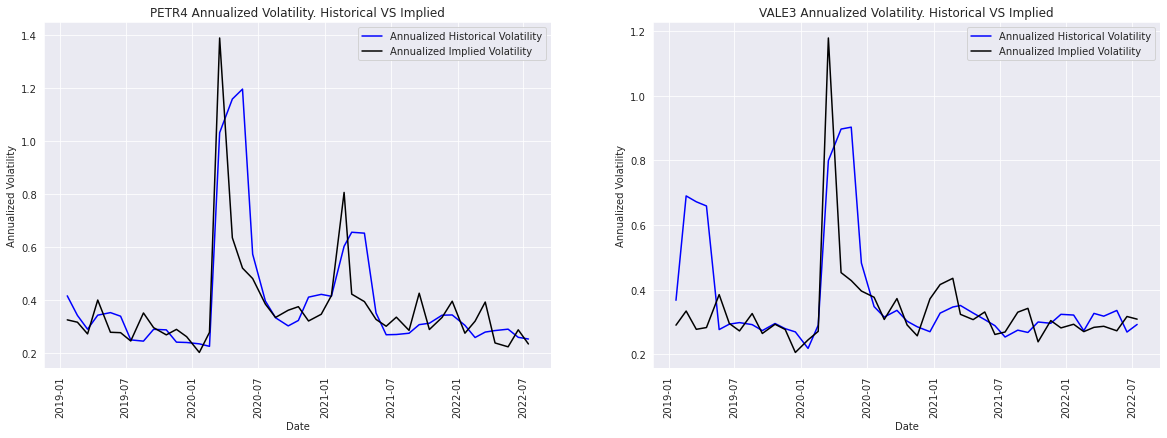

In [13]:
last_n_working_days = 60
min_date = datetime(year=2019, month=1, day=1) # Make sure there are at least 'last_n_working_days' days prior to min_date
max_date = datetime(year=2022, month=8, day=31)
dates = call_df_dict[PETR4_TICKER][call_df_dict[PETR4_TICKER]["data_vencimento"].between(min_date, max_date)]["data_vencimento"].unique()
dates.sort()

##### Historical Volatilities #####
petr4_annualized_hist_vols = []
vale3_annualized_hist_vols = []
for date in dates[:-1]:
    petr4_annualized_hist_vols.append(
        annualized_hist_volatility(stock_df_dict[PETR4_TICKER], end_date=date, offset=last_n_working_days)
    )
    vale3_annualized_hist_vols.append(
        annualized_hist_volatility(stock_df_dict[VALE3_TICKER], end_date=date, offset=last_n_working_days)
    )

##### Implied Volatilities #####
petr4_annualized_implied_vols = calculate_implied_volatilities(
    stock_df=stock_df_dict[PETR4_TICKER],
    call_df=call_df_dict[PETR4_TICKER],
    dates=dates,
)
vale3_annualized_implied_vols = calculate_implied_volatilities(
    stock_df=stock_df_dict[VALE3_TICKER],
    call_df=call_df_dict[VALE3_TICKER],
    dates=dates,
)

##### Graphs #####
plt.figure(figsize=(20,14))

plt.subplot(2, 2, 1)
_ = sns.lineplot(
    y=petr4_annualized_hist_vols, x=dates[:-1],
    label="Annualized Historical Volatility", color="b"
)
_ = sns.lineplot(
    y=petr4_annualized_implied_vols, x=dates[:-1],
    label="Annualized Implied Volatility", color="k"
)
plt.title("PETR4 Annualized Volatility. Historical VS Implied")
plt.ylabel(f"Annualized Volatility")
_ = plt.xlabel("Date")
_ = plt.xticks(rotation="vertical")

plt.subplot(2, 2, 2)
_ = sns.lineplot(
    y=vale3_annualized_hist_vols, x=dates[:-1],
    label="Annualized Historical Volatility", color="b"
)
_ = sns.lineplot(
    y=vale3_annualized_implied_vols, x=dates[:-1],
    label="Annualized Implied Volatility", color="k"
)
plt.title("VALE3 Annualized Volatility. Historical VS Implied")
plt.ylabel(f"Annualized Volatility")
_ = plt.xlabel("Date")
_ = plt.xticks(rotation="vertical")

### Intrinsic and Extrinsic Values

The value of an option consists of two parts: Intrinsic and Extrinsic.  
On the one hand, the intrinsic value of an options is the difference between the price of the underlying asset and the strike price of the option. The instrinsic value reflects the real value of an option and doesn't change with time. Here below, we have the equation to calculate the intrinsec value of a call and a put. It is worth noticing that the intrinsic value of a call is zero if the current stock price is less than the strike price. In this case, it is better for you to buy the stock directly instead of using the call (buy option), then the call is useless. A similar logic applies to the put options, since a put is worthless if the current stock price is higher than the strike price.

$$IV_c = max(S-K,0)$$
$$IV_p = max(K-S,0)$$

On the other hand, the extrinsic value is the value generated by the incertainty the time remaining on the contract and the implied volatility of the stock cause. The extrinsic value is the difference between the premium and the intrinsic value and decays with time.

$$EV_c = P_c - IV_c$$
$$EV_p = P_p - IV_p$$

In [ ]:
%%script false --no-raise-error

def calculate_intrinsic_value(
    option_df: pd.DataFrame,
    stock_df: pd.DataFrame,
    is_call: bool
) -> None:
    option_df["valor_intrinseco"] = option_df.apply(
        lambda row: max(
            stock_df[stock_df["data_pregao"] == row["data_pregao"]]["preco_ultimo_negocio"].iloc[0] - row["preco_exercicio"]
            if is_call
            else row["preco_exercicio"] - stock_df[stock_df["data_pregao"] == row["data_pregao"]]["preco_ultimo_negocio"].iloc[0],
            0
        ),
        axis=1
    )

### Calls ###
calculate_intrinsic_value(petr4_call_df, petr4_stock_df, is_call=True)
calculate_intrinsic_value(vale3_call_df, vale3_stock_df, is_call=True)

petr4_call_df["valor_extrinseco"] = petr4_call_df["preco_ultimo_negocio"] - petr4_call_df["valor_intrinseco"]
vale3_call_df["valor_extrinseco"] = vale3_call_df["preco_ultimo_negocio"] - vale3_call_df["valor_intrinseco"]

### Feature Engineering

#### Input
* [X] Implied Volatility, Historical Volatility and their ratio
* [X] Strike Margin.
* [X] Premium or how much the premium can protect you.
* [ ] Number of months in the past where S went above K for a given call and a given month.
* [ ] Something related to the moving average.
* [ ] Add some temporal variables such as the volatility of previous months.

#### Output
As a first approach, we can train our models to classify whether or not the next month will return profit if we apply the covered call strategy for some call. Then, we can sell call options by checking the ones more likely to result in profit. 
We could calculate the probability for every one and pick the most-likely one.


In [19]:
### Features ###
DATE_FEATURE = "date"
# Call price
PREMIUM_FEATURE = "premium"
# How much the stock can fall without profit loss
PREMIUM_PROTECTION_FEATURE = "premium_protection"
CURRENT_STOCK_PRICE_FEATURE = "stock_price"
STRIKE_DATE_FEATURE = "strike_date"
STRIKE_PRICE_FEATURE = "strike_price"
# Strike price divided by the current stock price
STRIKE_MARGIN_FEATURE = "strike_margin"
VOLUME_TRADED_FEATURE = "volume_traded"
HISTORICAL_VOLATILITY_FEATURE = "hist_volatility"
IMPLIED_VOLATILITY_FEATURE = "implied_volatility"
VEGA_FEATURE = "vega"
VOLATILITY_MARGIN_FEATURE = "volatility_margin"
LAST_100_DAYS_MOVING_AVERAGE_FEATURE = "last_100_days_moving_average"
STOCK_PRICE__MOVING_AVERAGE__RATIO_FEATURE = "stock_price_moving_average_ratio"
LAST_30_DAYS_BUY_AND_HOLD_RETURN_FEATURE = "last_30_days_return"
LAST_60_DAYS_BUY_AND_HOLD_RETURN_FEATURE = "last_60_days_return"
LAST_90_DAYS_BUY_AND_HOLD_RETURN_FEATURE = "last_90_days_return"
LAST_100_DAYS_MAX_PRICE_INTRADAY_FEATURE = "last_30_days_max_price_intraday"
# Rate of days the stock price was above the strike price in the last 90 days
STOCK_PRICE_ABOVE_STRIKE_PRICE_LAST_90_DAYS = "stock_price_above_strike_price_last_90_days"

### Targets ###
CC_NEXT_MONTH_RETURN_TARGET = "cc_next_month_return"
NEXT_MONTH_BUY_AND_HOLD_RETURN_TARGET = "next_month_buy_and_hold_return"
CC_BETTER_THAN_BUY_AND_HOLD_TARGET = "cc_better_than_buy_and_hold"
CC_BETTER_THAN_BUY_AND_HOLD_AMOUNT_TARGET = "cc_better_than_buy_and_hold_amount"

In [18]:
# @title Functions

class NoNegociationsOnDate(Exception):
    pass

def get_stock_price(
    stock_df: pd.DataFrame,
    date: datetime
) -> float:
    stock_price = stock_df[stock_df["data_pregao"] == date]["preco_ultimo_negocio"]
    if stock_price.shape[0] == 0: raise NoNegociationsOnDate(f"No negociations on date: {date}")
    return stock_price.iloc[0]

def calculate_single_month_cc_return(call_option: pd.Series, stock_df: pd.DataFrame,):
    """
    Calculate the return at call_option["data_vencimento"] if we bought a stock
    at call_option["data_pregao"] and sold call_option
    """
    try:
        current_stock_price = get_stock_price(stock_df=stock_df, date=call_option["data_pregao"])
        next_month_stock_price = get_stock_price(stock_df=stock_df, date=call_option["data_vencimento"])
    except NoNegociationsOnDate as e:
        return np.nan

    premium = call_option["preco_ultimo_negocio"]
    initial_amount = current_stock_price
    final_amount = min(next_month_stock_price, call_option["preco_exercicio"]) + premium

    return (final_amount - initial_amount)/initial_amount

def calculate_buy_and_hold_return(stock_df: pd.DataFrame, start_date: datetime, end_date: datetime):

    dates = stock_df["data_pregao"].unique()
    try:
        current_stock_price = get_stock_price(stock_df=stock_df, date=start_date if start_date in dates else start_date - timedelta(days=2))
        next_month_stock_price = get_stock_price(stock_df=stock_df, date=end_date if end_date in dates else end_date + timedelta(days=2))
    except NoNegociationsOnDate as e:
        return np.nan
    
    return (next_month_stock_price - current_stock_price)/current_stock_price

def calculate_moving_average(stock_df: pd.DataFrame, date: datetime, offset: int):
    return stock_df[
        (stock_df["data_pregao"] >= (date - timedelta(days=offset)))
        & (stock_df["data_pregao"] < date)
    ]["preco_ultimo_negocio"].mean()

def calculate_max_price_intraday(stock_df: pd.DataFrame, date: datetime, offset: int) -> float:
    return stock_df[
        (stock_df["data_pregao"] >= (date - timedelta(days=offset)))
        & (stock_df["data_pregao"] < date)
    ]["preco_maximo"].max()

def calculate_rate_of_days_stock_above_strike(strike_price: float, stock_df: pd.DataFrame, date: datetime, offset: int) -> float:

    last_days_stock_df = stock_df[
        (stock_df["data_pregao"] >= (date - timedelta(days=offset)))
        & (stock_df["data_pregao"] < date)
    ]
    return (last_days_stock_df["preco_ultimo_negocio"] > strike_price).sum()/last_days_stock_df.shape[0]

def build_call_features(
    call_option: pd.Series,
    stock_df: pd.DataFrame,
    last_n_working_days: int,
):

    stock_price = get_stock_price(stock_df, call_option["data_pregao"])
    call_features = dict()

    call_features[DATE_FEATURE] = call_option["data_pregao"]
    call_features[CURRENT_STOCK_PRICE_FEATURE] = stock_price
    call_features[PREMIUM_FEATURE] = call_option["preco_ultimo_negocio"]
    call_features[PREMIUM_PROTECTION_FEATURE] = call_option["preco_ultimo_negocio"]/stock_price
    call_features[STRIKE_DATE_FEATURE] = call_option["data_vencimento"]
    call_features[STRIKE_PRICE_FEATURE] = call_option["preco_exercicio"]
    call_features[STRIKE_MARGIN_FEATURE] = (
        call_option["preco_exercicio"] - stock_price
    )/stock_price
    call_features[VOLUME_TRADED_FEATURE] = call_option["volume_total_negociado"]
    call_features[HISTORICAL_VOLATILITY_FEATURE] = annualized_hist_volatility(
        stock_df,
        end_date=call_option["data_pregao"],
        offset=last_n_working_days
    )
    call_features[IMPLIED_VOLATILITY_FEATURE] = implied_volatility_call(
        call_price=call_option["preco_ultimo_negocio"],
        stock_price=stock_price,
        strike_price=call_option["preco_exercicio"],
        time_to_maturity=(call_option["data_vencimento"] - call_option["data_pregao"]).days/365,
        risk_free_rate=get_current_selic(call_option["data_pregao"]),
    )
    call_features[VEGA_FEATURE] = vega(
        stock_price=stock_price,
        strike_price=call_option["preco_exercicio"],
        time_to_maturity=(call_option["data_vencimento"] - call_option["data_pregao"]).days/365,
        risk_free_rate=get_current_selic(call_option["data_pregao"]),
        volatility=call_features[HISTORICAL_VOLATILITY_FEATURE]
    )
    call_features[VOLATILITY_MARGIN_FEATURE] = (call_features[IMPLIED_VOLATILITY_FEATURE]/call_features[HISTORICAL_VOLATILITY_FEATURE]) - 1
    call_features[LAST_100_DAYS_MOVING_AVERAGE_FEATURE] = calculate_moving_average(stock_df, date=call_option["data_pregao"], offset=100)
    call_features[STOCK_PRICE__MOVING_AVERAGE__RATIO_FEATURE] = stock_price/call_features[LAST_100_DAYS_MOVING_AVERAGE_FEATURE]
    call_features[LAST_30_DAYS_BUY_AND_HOLD_RETURN_FEATURE] = calculate_buy_and_hold_return(
        stock_df,
        call_option["data_pregao"] - timedelta(days=30),
        call_option["data_pregao"]
    )
    call_features[LAST_60_DAYS_BUY_AND_HOLD_RETURN_FEATURE] = calculate_buy_and_hold_return(
        stock_df,
        call_option["data_pregao"] - timedelta(days=60),
        call_option["data_pregao"]
    )
    call_features[LAST_90_DAYS_BUY_AND_HOLD_RETURN_FEATURE] = calculate_buy_and_hold_return(
        stock_df,
        call_option["data_pregao"] - timedelta(days=90),
        call_option["data_pregao"]
    )
    call_features[LAST_100_DAYS_MAX_PRICE_INTRADAY_FEATURE] = calculate_max_price_intraday(
        stock_df,
        date=call_option["data_pregao"],
        offset=100
    )
    call_features[STOCK_PRICE_ABOVE_STRIKE_PRICE_LAST_90_DAYS] = calculate_rate_of_days_stock_above_strike(
        strike_price=call_option["preco_exercicio"],
        stock_df=stock_df,
        date=call_option["data_pregao"],
        offset=90
    )

    call_features[CC_NEXT_MONTH_RETURN_TARGET] = calculate_single_month_cc_return(call_option, stock_df)
    call_features[NEXT_MONTH_BUY_AND_HOLD_RETURN_TARGET] = calculate_buy_and_hold_return(stock_df, call_option["data_pregao"], call_option["data_vencimento"])
    call_features[CC_BETTER_THAN_BUY_AND_HOLD_TARGET] = call_features[CC_NEXT_MONTH_RETURN_TARGET] > call_features[NEXT_MONTH_BUY_AND_HOLD_RETURN_TARGET]
    call_features[CC_BETTER_THAN_BUY_AND_HOLD_AMOUNT_TARGET] = call_features[CC_NEXT_MONTH_RETURN_TARGET] - call_features[NEXT_MONTH_BUY_AND_HOLD_RETURN_TARGET]

    return pd.Series(call_features)

def create_ml_df(
    stock_df: pd.DataFrame, 
    call_df: pd.DataFrame,
    start_date: datetime,
    end_date: datetime,
    last_n_working_days: int,
) -> pd.DataFrame:

    dates = call_df[call_df["data_vencimento"] <= end_date]["data_vencimento"].unique()
    dates.sort()
    filtered_call_df = call_df[call_df["data_pregao"].isin(dates) & (call_df["data_pregao"] > start_date)]
    
    ### Features ###
    ml_df_ = filtered_call_df.apply(lambda row: build_call_features(
        call_option=row,
        stock_df=stock_df,
        last_n_working_days=last_n_working_days,
    ), axis=1)

    ### Build the machine learning Dataframe ###
    return ml_df_.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

def calculate_profit_proba(
    call_features: pd.Series,
    classifier: ClassifierMixin,
) -> float:
    return classifier.predict_proba([call_features.to_list()])[0][1]

#### Datasets

In [20]:
feature_df_map: Dict[str, pd.DataFrame] = {}

progress_bar = tqdm(stock_df_dict.keys(), leave=False)
for ticker in progress_bar:
    progress_bar.set_description(ticker)

    feature_df_map[ticker] = create_ml_df(
        stock_df=stock_df_dict[ticker],
        call_df=call_df_dict[ticker],
        start_date=datetime(year=2019, month=1, day=1),
        end_date=datetime(year=2022, month=8, day=31),
        last_n_working_days=60,
    )

    better_than_buy_and_hold_percentage = feature_df_map[ticker][CC_BETTER_THAN_BUY_AND_HOLD_TARGET].sum()/feature_df_map[ticker].shape[0]
    print(f"{ticker}: {100*better_than_buy_and_hold_percentage:.2f}% of call options better than Buy and Hold")

feature_df_map[PETR4_TICKER].to_csv(DATA_FOLDER_PATH + "final_data/petr4_features.csv", index=False)
feature_df_map[VALE3_TICKER].to_csv(DATA_FOLDER_PATH + "final_data/vale3_features.csv", index=False)
feature_df_map[ITUB4_TICKER].to_csv(DATA_FOLDER_PATH + "final_data/itub4_features.csv", index=False)
feature_df_map[BBAS3_TICKER].to_csv(DATA_FOLDER_PATH + "final_data/bbas3_features.csv", index=False)
feature_df_map[ABEV3_TICKER].to_csv(DATA_FOLDER_PATH + "final_data/abev3_features.csv", index=False)
feature_df_map[BBDC4_TICKER].to_csv(DATA_FOLDER_PATH + "final_data/bbdc4_features.csv", index=False)
feature_df_map[BOVA11_TICKER].to_csv(DATA_FOLDER_PATH + "final_data/bova11_features.csv", index=False)

  0%|          | 0/7 [00:00<?, ?it/s]

PETR4: 65.13% of call options better than Buy and Hold
VALE3: 69.58% of call options better than Buy and Hold
ITUB4: 79.45% of call options better than Buy and Hold
BBAS3: 78.28% of call options better than Buy and Hold
ABEV3: 82.44% of call options better than Buy and Hold
BBDC4: 80.77% of call options better than Buy and Hold
BOVA11: 75.34% of call options better than Buy and Hold


In [ ]:
# @title Load data

feature_df_map = {}
for ticker in [
    PETR4_TICKER,
    VALE3_TICKER,
    ITUB4_TICKER,
    BBAS3_TICKER,
    ABEV3_TICKER,
    BBDC4_TICKER,
    BOVA11_TICKER,
]:
    feature_df_map[ticker] = pd.read_csv(
        DATA_FOLDER_PATH + f"final_data/{ticker.lower()}_features.csv",
        parse_dates=[DATE_FEATURE, STRIKE_DATE_FEATURE],
        date_parser=lambda date_str: datetime.strptime(date_str, "%Y-%m-%d")
    )

### Analysis

In [24]:
features = [
    PREMIUM_FEATURE,
    PREMIUM_PROTECTION_FEATURE,
    CURRENT_STOCK_PRICE_FEATURE,
    STRIKE_PRICE_FEATURE,
    STRIKE_MARGIN_FEATURE,
    VOLUME_TRADED_FEATURE,
    HISTORICAL_VOLATILITY_FEATURE,
    IMPLIED_VOLATILITY_FEATURE,
    VEGA_FEATURE,
    VOLATILITY_MARGIN_FEATURE,
    LAST_100_DAYS_MOVING_AVERAGE_FEATURE,
    STOCK_PRICE__MOVING_AVERAGE__RATIO_FEATURE,
    LAST_30_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_60_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_90_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_100_DAYS_MAX_PRICE_INTRADAY_FEATURE,
    STOCK_PRICE_ABOVE_STRIKE_PRICE_LAST_90_DAYS,
]

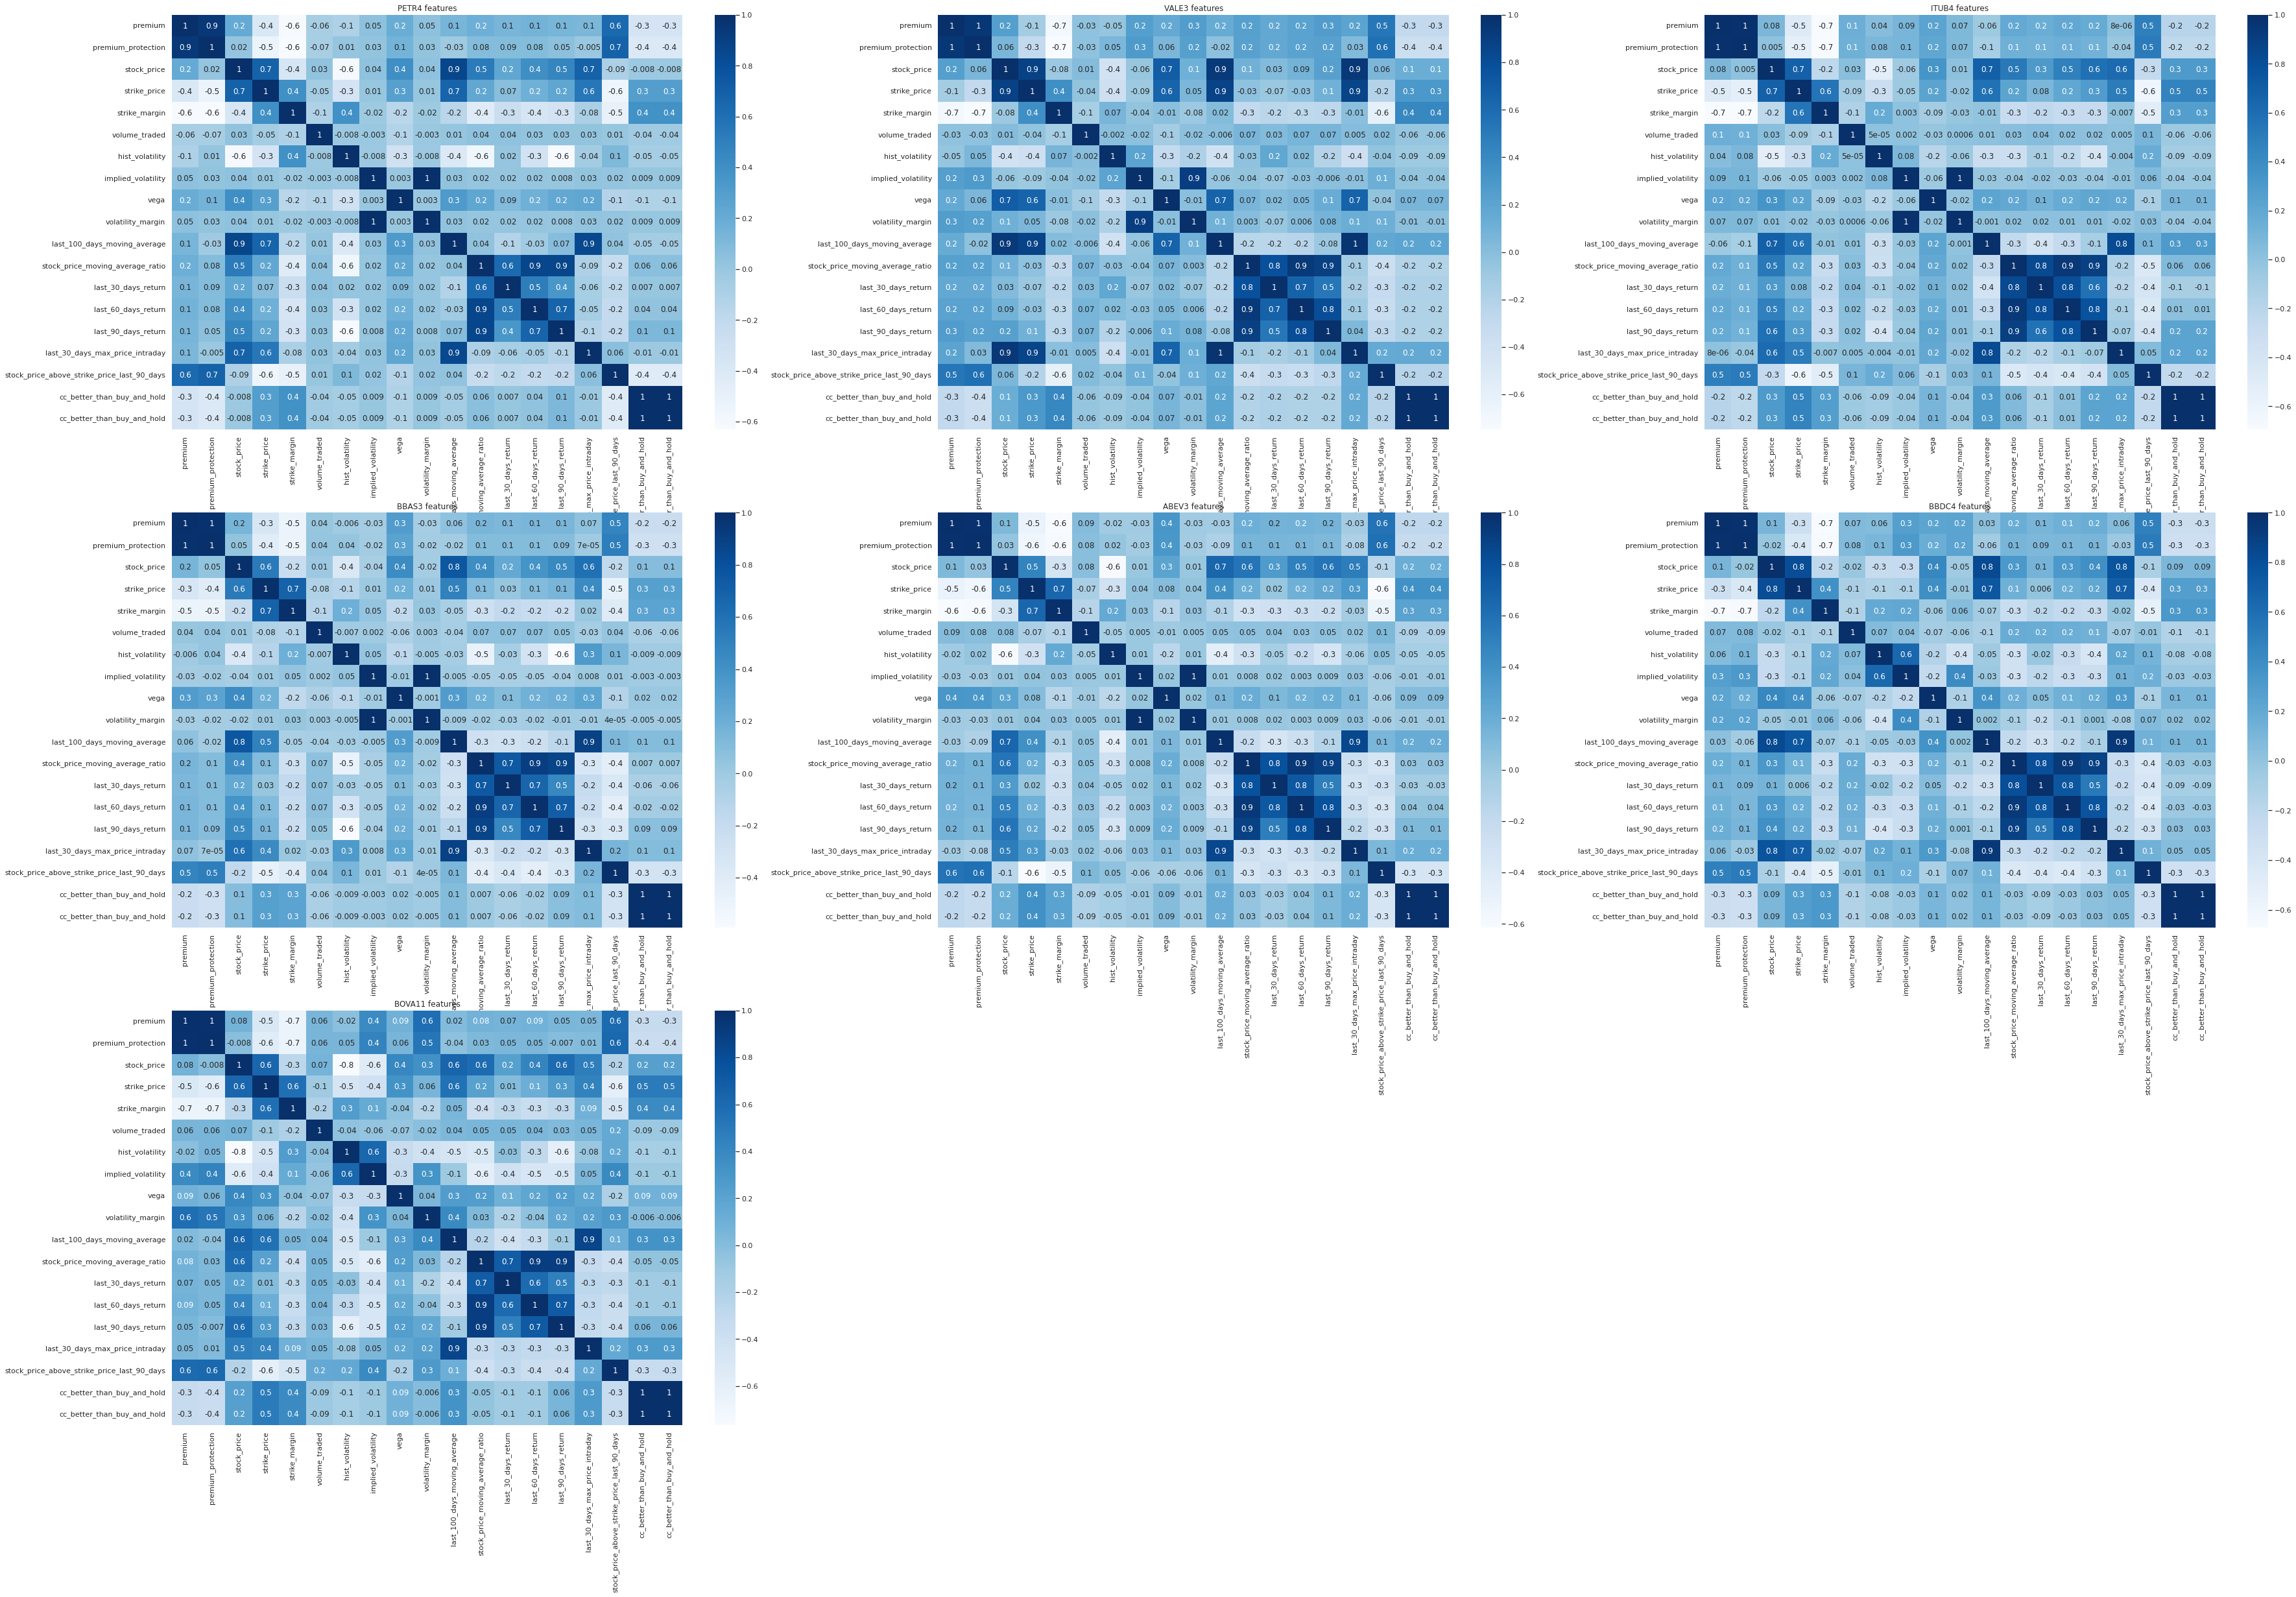

In [23]:
# @title Correlation

plt.figure(figsize=(60,40))
sns.set_theme(style="white")

for idx, ticker in enumerate(feature_df_map.keys()):
    plt.subplot(3, 3, idx+1)
    plt.title(f"{ticker} features")
    corr = feature_df_map[ticker][[*features, CC_BETTER_THAN_BUY_AND_HOLD_TARGET]].corr()
    heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

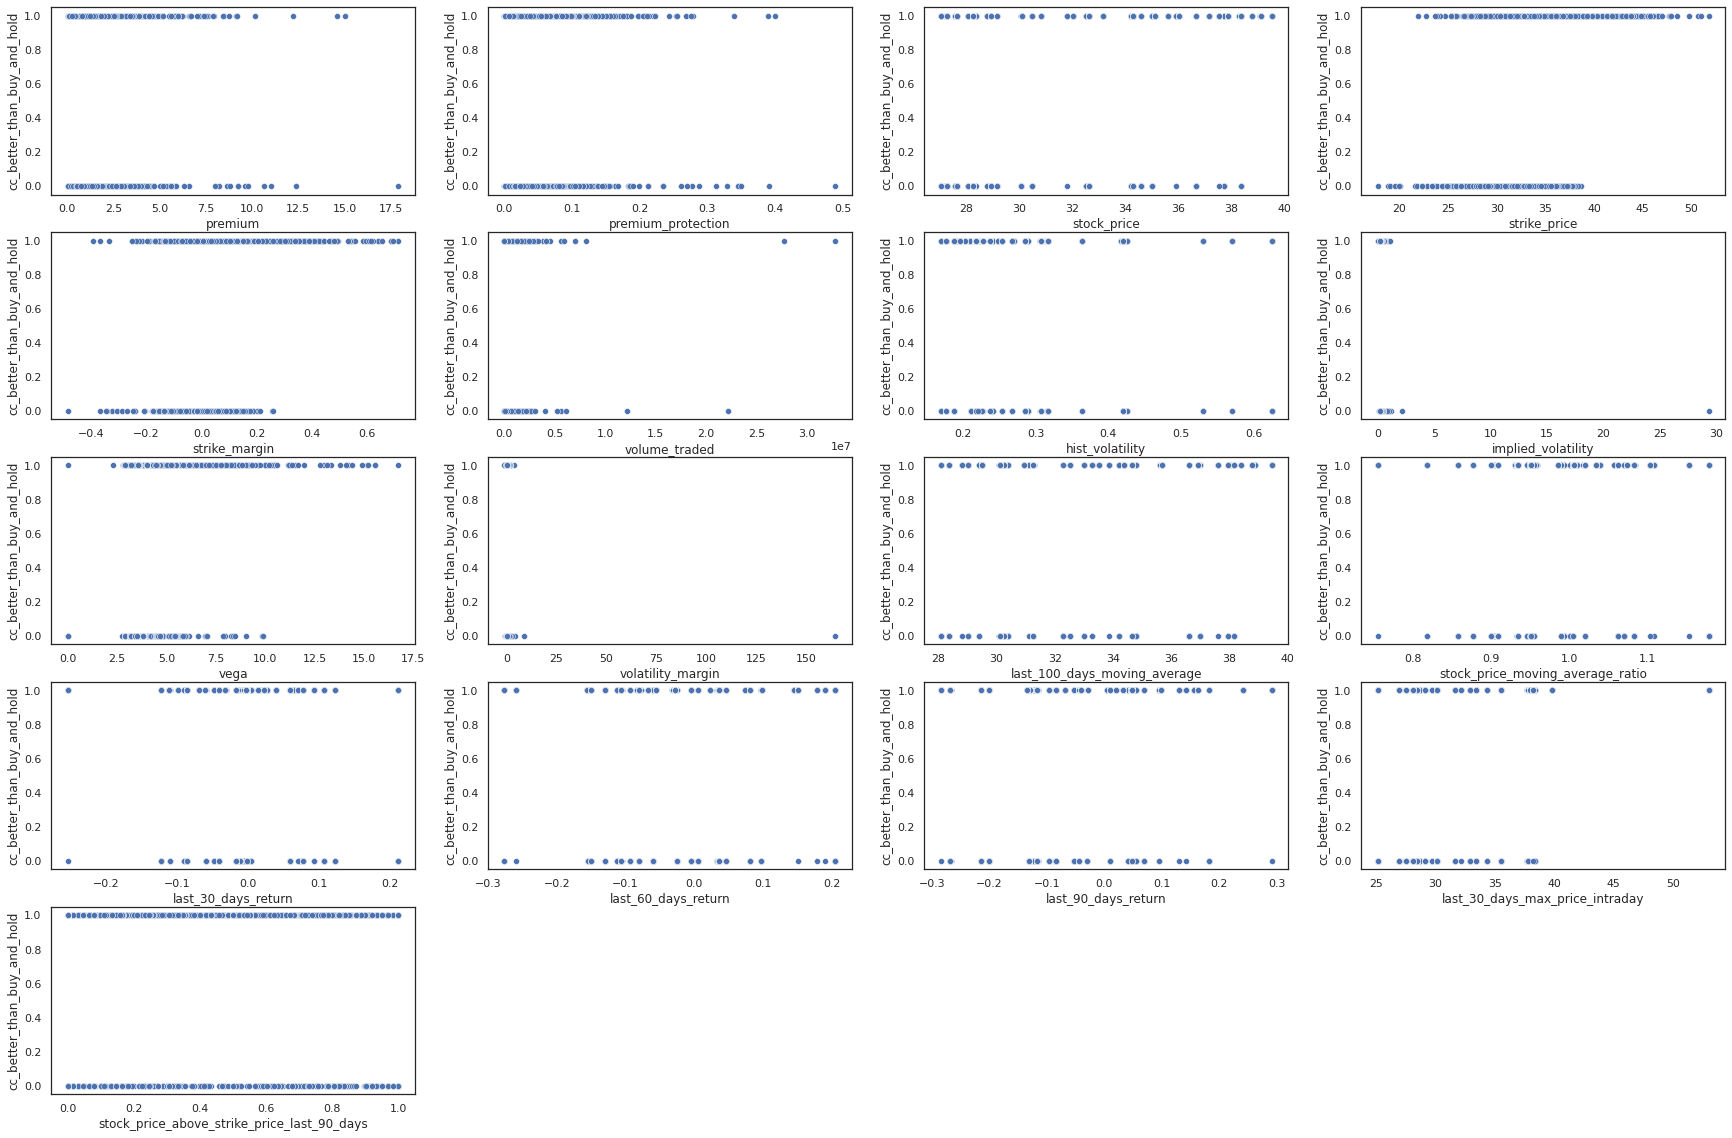

In [33]:
# @title Scatter Plot

ticker = "ITUB4"

plt.figure(figsize=(30,20))
n_sqrt = len(features)**(1/2)
n = math.floor(n_sqrt)
for idx, feature in enumerate(features):
    plt.subplot(n if n==n_sqrt else n+1, n, idx+1)
    sns.scatterplot(data=feature_df_map[ticker], x=feature, y=CC_BETTER_THAN_BUY_AND_HOLD_TARGET)

## References

* https://playinvest.com.br/

* Dividends PETR4: https://www.investidorpetrobras.com.br/acoes-dividendos-e-dividas/dividendos-e-jcp/

* Dividends VALE3: https://playinvest.com.br/dividendos/vale3

* Dividends ITUB4: https://www.itau.com.br/relacoes-com-investidores/itau-unibanco/nossas-acoes/acoes-dividendos-e-jcp/

* The link to the historical data can be found at: https://www.b3.com.br/en_us/market-data-and-indices/data-services/market-data/historical-data/equities/historical-quotes/

* Volatility smile: https://www.investopedia.com/terms/v/volatilitysmile.asp

* A helpful site to understand how to parse the data: https://github.com/tumenas/PythonFinancas/blob/main/leitura_b3.ipynb  

* For more information about how the data is formatted, check out the file data/SeriesHistoricas_Layout.pdf

* Stock options strategies: https://www.researchgate.net/publication/313238749

* Volatility: https://www.codearmo.com/blog/implied-volatility-european-call-python; https://riconnect.rico.com.vc/blog/volatilidade; https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/consultas/mercado-a-vista/volatilidades-dos-ativos/desvio-padrao/

* Black-Scholes Model: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model

* Selic rate: https://www.bcb.gov.br/controleinflacao/historicotaxasjuros

* https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

* https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-binary-classification-49596d7dcabf

## Notes


* Melhoria no covered call com volatilidade: Agora só vendemos a call se achamos de fato uma opção que respeite a margem de volatilidade. Por exemplo, se a margem for 10% e tivermos uma tolerância de 3%, quer dizer que vamos considerar todas as call que tenham volatilidade implícita entre 7% e 13% acima da volatilidade histórica. No caso de haver mais que uma, pegamos aquela com maior prêmio. Além disso, só consideramos calls que tenham preço de strike x% (definido através de strike_margin_threshold) maior que o valor da ação no momento da escolha 

### TODO
* [ ] CDI ao longo do tempo
* [ ] Quando fazer rolagem?
* [ ] Ver questão do volume na cc com strike_margin
* [ ] Normalizar os dados
* [ ] Ver aquelas curvas de AUC
* [ ] Correlação
* [ ] Ver quais variáveis são importantes e criar outras.



* Diferença com o min/max histórico.
* Prob de subir.
* Max intraday.
* Comparar estratégias.
* Quantas vezes não houve venda de calls.
* Quantas vezes foi exercido.
* Indicadores de análise técnica.
* Restringir o range de margem.
* Restringir datas de vencimento

In [ ]:
%cd drive/MyDrive/UFC/TCC_STOCK_OPTIONS/stock-options/
!git config --global user.email "luikymagno@gmail.com"
!git config --global user.name "luikymagno"

!git add -A
!git commit -m "WIP: Neural Network"
!git push

/content/drive/MyDrive/UFC/TCC_STOCK_OPTIONS/stock-options
[main 67b0a0b] WIP: Neural Network
 8 files changed, 21650 insertions(+), 1 deletion(-)
 create mode 100644 data/processed_data/abev3_ml.csv
 create mode 100644 data/processed_data/bbas3_ml.csv
 create mode 100644 data/processed_data/bbdc4_ml.csv
 create mode 100644 data/processed_data/bova11_ml.csv
 create mode 100644 data/processed_data/itub4_ml.csv
 create mode 100644 data/processed_data/petr4_ml.csv
 create mode 100644 data/processed_data/vale3_ml.csv
Counting objects: 12, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 1.24 MiB | 2.38 MiB/s, done.
Total 12 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/luikymagno/stock-options
   ecaa1a2..67b0a0b  main -> main
